In [1]:
#import modin.pandas as pd
import os
import time
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gc

In [2]:
time_resolution = 1

## Entropy Network

+ View the Dataset here, read from the saved csv
++ Route('../author_data/emails/')

In [4]:
#c_path = '/mnt/data0/lkyin/monthly_data/commits/'
c_path = '../author_data/commits/'
projects = os.listdir(c_path)

In [5]:
len(projects)

6580

In [6]:
proj_names = []
for project in tqdm(projects):
    project_name, period = project.replace('.csv', '').split('__')
    proj_names.append(project_name)

pd_proj_names = pd.Series(proj_names)
pd_proj_names.describe()

100%|██████████| 6580/6580 [00:00<00:00, 1458387.25it/s]


count        6580
unique        263
top       airflow
freq          383
dtype: object

In [7]:
df_commits = pd.read_csv(c_path+projects[0])
df_commits.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'sender_email', 'author_name', 'author_email',
       'file_name', 'loc', 'ref_or_sha', 'subject', 'commit_type',
       'author_full_name', 'is_bot', 'is_coding', 'dealised_author_full_name'],
      dtype='object')

In [8]:
df_commits.describe()

,month,loc
count,89.000000,89.000000
mean,7.404494,37.606742
std,1.635675,49.956030
min,4.000000,1.000000
25%,8.000000,8.000000
50%,8.000000,18.000000
75%,8.000000,42.000000
max,9.000000,269.000000


In [9]:
df_commits.head(5)

,project_name,list_name,date,month,message_id,sender_name,sender_email,author_name,author_email,file_name,loc,ref_or_sha,subject,commit_type,author_full_name,is_bot,is_coding,dealised_author_full_name
0,taverna,commits,2015-02-17 11:18:03,4,<0526c3c6e5f5458c9c995321dc61cba0@git.apache.org>,stain,stain@apache.org,Alan R Williams,alan.r.williams@manchester.ac.uk,.../taverna/databundle/TestFullExample.java,77.0,None,[47/52] [abbrv] incubator-taverna-language git...,git,alan r williams,False,True,Alan Williams
1,taverna,commits,2015-02-17 11:18:03,4,<0526c3c6e5f5458c9c995321dc61cba0@git.apache.org>,stain,stain@apache.org,Alan R Williams,alan.r.williams@manchester.ac.uk,.../apache/taverna/robundle/TestExample.java,21.0,None,[47/52] [abbrv] incubator-taverna-language git...,git,alan r williams,False,True,Alan Williams
2,taverna,commits,2015-02-17 11:18:03,4,<0526c3c6e5f5458c9c995321dc61cba0@git.apache.org>,stain,stain@apache.org,Alan R Williams,alan.r.williams@manchester.ac.uk,.../taverna/robundle/manifest/TestManifest.java,17.0,None,[47/52] [abbrv] incubator-taverna-language git...,git,alan r williams,False,True,Alan Williams
3,taverna,commits,2015-02-17 11:18:03,4,<0526c3c6e5f5458c9c995321dc61cba0@git.apache.org>,stain,stain@apache.org,Alan R Williams,alan.r.williams@manchester.ac.uk,.../robundle/manifest/TestManifestJSON.java,2.0,None,[47/52] [abbrv] incubator-taverna-language git...,git,alan r williams,False,True,Alan Williams
4,taverna,commits,2015-02-17 11:18:03,4,<0526c3c6e5f5458c9c995321dc61cba0@git.apache.org>,stain,stain@apache.org,Alan R Williams,alan.r.williams@manchester.ac.uk,.../manifest/combine/TestCombineManifest.java,22.0,None,[47/52] [abbrv] incubator-taverna-language git...,git,alan r williams,False,True,Alan Williams


## ASF Techinical Network Construction from Likang
+ Using NetworkX for analysis
    + https://www.osgeo.cn/networkx/tutorial.html#attributes

    + Use Pandas with NetworkX https://www.jianshu.com/p/11456474d8a5

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null (SVN has 'noauthor')
    + For each row:
        + Check if file name exist as node
        + Add file as Node
        + Edges saved in mk_tech_net as a set
        + for each commit on each file, weight +1
    + Use mk_tech_net to construct graph
        + Network attributes from the dictionary: https://www.osgeo.cn/networkx/tutorial.html#attributes

In [11]:
#c_path = '/mnt/data0/lkyin/monthly_data/commits/'
c_path = '../author_data/commits/'
projects = os.listdir(c_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
to_path = './entropynet_data/commits/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
gx_technets = []
for project in tqdm(projects):
    mk_tech_net = {}
    project_name, period = project.replace('.csv', '').split('__')
    #if int(period)%time_resolution!=0 :
    #    continue
    fnames = [project_name+'__'+str(int(period))+'.csv']
    for fname in fnames:
        if not os.path.exists(c_path+fname):
            continue
        df = pd.read_csv(c_path+fname)
        df.query('is_bot == False and is_coding == True', inplace=True)
        df = df[df['dealised_author_full_name'].notna()].sort_values(by=['dealised_author_full_name'])
        for index, row in df.iterrows():
            if index == 0:
                prev_file_name = row['dealised_author_full_name']
                continue
            file_path = row['file_name']
            # file extension = '.' + file_path.split('/')[-1].split('.')[-1].split(' ')[0]
            file_name = file_path
            if prev_file_name not in mk_tech_net:
                mk_tech_net[prev_file_name] = {}
            
            if file_name not in mk_tech_net[prev_file_name]:
                mk_tech_net[prev_file_name][file_name] = {}
                mk_tech_net[prev_file_name][file_name]['weight'] = 0
            mk_tech_net[prev_file_name][file_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(mk_tech_net)
    # add disconnected nodes
    g.add_nodes_from(mk_tech_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_technets.append(g)

100%|██████████| 6580/6580 [05:05<00:00, 21.52it/s] 


In [30]:
mk_tech_net


{}

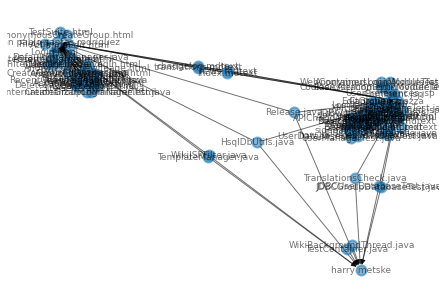

In [31]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

## ASF Social Networks Construction From Likang

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null
    + For each email:
        + Check if this email have previous references, if not, quit and go next
        + Add previous authors as Nodes
        + Edges saved in social_net as a node
        + for each email sent to previous edges on each file, mutually (sender to previous & previous to sender) weight +1

In [13]:
#e_path = '/mnt/data0/lkyin/monthly_data/emails/'
e_path = '../author_data/emails/'
projects = os.listdir(e_path)

In [14]:
for project in tqdm(projects[:1]):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    df = pd.read_csv(e_path+project)
    df.query('is_bot == False', inplace=True)
    df = df[df['dealised_author_full_name'].notna()]

100%|██████████| 1/1 [00:00<00:00, 111.13it/s]


In [15]:
df.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'references', 'sender_email', 'in_reply_to', 'cc_list',
       'receiver_email', 'subject', 'body', 'from_commit', 'author_full_name',
       'is_bot', 'dealised_author_full_name'],
      dtype='object')

In [35]:
df.describe()

,month
count,62.0
mean,2.0
std,0.0
min,2.0
25%,2.0
50%,2.0
75%,2.0
max,2.0


In [36]:
df.head(5)

,project_name,list_name,date,month,message_id,sender_name,references,sender_email,in_reply_to,cc_list,receiver_email,subject,body,from_commit,author_full_name,is_bot,dealised_author_full_name
0,taverna,dev,2014-12-01 01:11:07,2.0,<CAPRnXtmtwnMV_x38qy8MOtCCCgW2dLBZ05yPxQUty7Hk...,Stian Soiland-Reyes,<CACnO1SHVo5aBWxe1DdXWkgKcFE2c1K0_Lv=UtGv=c9+t...,soiland-reyes@cs.manchester.ac.uk,<CACnO1SHnGxKcWNn380k2pCpn5zq=nBQPUsyYHVmk5Umx...,None,Nebojsa Tijanic <nebojsa.tijanic@sbgenomics.co...,Re: Workflow model,(dev@taverna - you might see that I occasional...,False,stian soilandreyes,False,Stian Soiland-reyes
1,taverna,dev,2014-12-01 09:38:25,2.0,<547C3711.5030702@apache.org>,Andy Seaborne,<5471BEAB.2070406@apache.org> <5473422B.300080...,andy@apache.org,<CAPRnXtkA2FhS_tuZA61P+kKxSE_paS9EkBvpeEpkwZ3Q...,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,Report signed off by me.\nIf the other mentors...,False,andy seaborne,False,Andy Seaborne
2,taverna,dev,2014-12-01 09:09:28,2.0,<547C7698.2040606@iu.edu>,Marlon Pierce,<5471BEAB.2070406@apache.org> <5473422B.300080...,marpierc@iu.edu,<547C3711.5030702@apache.org>,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,I'll sign off but I don't have edit privileges...,False,marlon pierce,False,Marlon Pierce
3,taverna,dev,2014-12-01 14:14:46,2.0,<BB3E9C4E-5430-4F8A-AD60-090776A41A00@16degree...,Gavin McDonald,<5471BEAB.2070406@apache.org> <5473422B.300080...,gavin@16degrees.com.au,<547C7698.2040606@iu.edu>,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,"\nOn 01/12/2014, at 2:09 PM, Marlon Pierce <ma...",False,gavin mcdonald,False,Gavin Mcdonald
4,taverna,dev,2014-12-01 09:16:36,2.0,<547C7844.3020000@iu.edu>,Marlon Pierce,<5471BEAB.2070406@apache.org> <5473422B.300080...,marpierc@iu.edu,<BB3E9C4E-5430-4F8A-AD60-090776A41A00@16degree...,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,"I have. I'm MarlonPierce.\n\nOn 12/1/14, 9:14 ...",False,marlon pierce,False,Marlon Pierce


In [3]:
to_path = './entropynet_data/emails/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
#e_path = '/mnt/data0/lkyin/monthly_data/emails/'
e_path = '../author_data/emails/'
projects = os.listdir(e_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
gx_socialnets = []
for project in tqdm(projects):
    # Here period mean individual authors
    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    fnames = [project_name+'__'+str(int(period))+'.csv']
    
    projdfname = project_name+'__0.csv'
    #if not os.path.exists(projdfname):
    #    continue
    projdf = pd.read_csv(e_path+projdfname)
    for index, row in projdf.iterrows():
        message_id = row['message_id'].strip()
        # print(row['dealised_author_full_name'])
        prev_prev_author = row['dealised_author_full_name']
        emailID_to_author[message_id] = prev_prev_author

    for fname in fnames:
        if not os.path.exists(e_path+fname):
            continue
        df = pd.read_csv(e_path+fname)
        df.query('is_bot == False', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        
        
        # raise KeyError
        for index, row in df.iterrows():
            message_id = row['message_id']
            references = row['references']
            prev_prev_author = row['dealised_author_full_name']

            # ignores if this email does not to previous emails
            if pd.isna(references) or references == 'None':
                continue

            references = [r.strip() for r in references.replace('\n', ' ').replace('\t', ' ').split(' ') if r.strip()]

            # deal with the issue that a line breaker exists in message_id:
            # e.g., <4\n829AB62.6000302@apache.org>
            new_refs = set()
            for i in range(len(references)-1):
                if '<' in references[i] and '>' not in references[i] and '<' not in references[i+1] and '>' in references[i+1]:
                    new_refs.add(references[i] + references[i+1])
            for r in references:
                if '<' in r and '>' in r:
                    new_refs.add(r)
            prev_prev_author = None
            references = new_refs
            for reference_id in references:
                if reference_id not in emailID_to_author:
                    continue
                prev_author = emailID_to_author[reference_id]
                # if it's the same person, continue
                if prev_author == prev_prev_author:
                    continue
                if not(prev_prev_author):
                    prev_prev_author = prev_author
                    continue
                if prev_prev_author not in social_net:
                    social_net[prev_prev_author] = {}
                if prev_author not in social_net:
                    social_net[prev_author] = {}

                # if node B replies node A, it means B sends signal to A
                if prev_author not in social_net[prev_prev_author]:
                    social_net[prev_prev_author][prev_author] = {}
                    social_net[prev_prev_author][prev_author]['weight'] = 0
                social_net[prev_prev_author][prev_author]['weight'] += 1

    gc.collect()
    
    #save as directed graph
    g = nx.DiGraph(social_net)
    # add disconnected nodes
    g.add_nodes_from(social_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_socialnets.append(g)

  0%|          | 18/51641 [00:13<9:14:09,  1.55it/s] /home/orzwang/.pyenv/versions/3.8.10/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
  3%|▎         | 1733/51641 [13:02<5:10:05,  2.68it/s] 

In [38]:
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
projects

['datasketches__1.csv',
 'twill__1.csv',
 'samoa__1.csv',
 'horn__1.csv',
 'npanday__1.csv',
 's4__1.csv',
 'kitty__1.csv',
 'oodt__1.csv',
 'groovy__1.csv',
 'phoenix__1.csv',
 'nmaven__1.csv',
 'stanbol__1.csv',
 'gobblin__1.csv',
 'sanselan__1.csv',
 'stratos__1.csv',
 'jspwiki__1.csv',
 'ariatosca__1.csv',
 'impala__1.csv',
 'taverna__1.csv',
 'libcloud__1.csv',
 'openaz__1.csv',
 'provisionr__1.csv',
 'jackrabbit__1.csv',
 'openwhisk__1.csv',
 'ant__1.csv',
 'hdt__1.csv',
 'couchdb__1.csv',
 'esme__1.csv',
 'kalumet__1.csv',
 'vxquery__1.csv',
 'gora__1.csv',
 'heraldry__1.csv',
 'directmemory__1.csv',
 'usergrid__1.csv',
 'commonsrdf__1.csv',
 'bigtop__1.csv',
 'flume__1.csv',
 'joshua__1.csv',
 'mrql__1.csv',
 'hawq__1.csv',
 'unomi__1.csv',
 'hise__1.csv',
 'servicecomb__1.csv',
 'roller__1.csv',
 'superset__1.csv',
 'alois__1.csv',
 'weex__1.csv',
 'wicket__1.csv',
 'jclouds__1.csv',
 'sqoop__1.csv',
 'geode__1.csv',
 'xmlbeans__1.csv',
 'nutch__1.csv',
 'dubbo__1.csv',
 'quic

In [39]:
social_net

{'Svante Schubert': {'Andrew Willerding': {'weight': 16},
  'David Fisher': {'weight': 4},
  'Yegor Kozlov': {'weight': 1},
  'Michael Stahl': {'weight': 1}},
 'Andrew Willerding': {'Svante Schubert': {'weight': 16}},
 'Tom Barber': {'David Fisher': {'weight': 2}},
 'David Fisher': {'Tom Barber': {'weight': 2},
  'Nick Burch': {'weight': 1},
  'Danese Cooper': {'weight': 1},
  'Yegor Kozlov': {'weight': 2},
  'Svante Schubert': {'weight': 4},
  'Michael Stahl': {'weight': 1}},
 'Nick Burch': {'David Fisher': {'weight': 1}},
 'Danese Cooper': {'David Fisher': {'weight': 1}},
 'Yegor Kozlov': {'David Fisher': {'weight': 2},
  'Svante Schubert': {'weight': 1}},
 'Michael Stahl': {'Svante Schubert': {'weight': 1},
  'David Fisher': {'weight': 1}}}

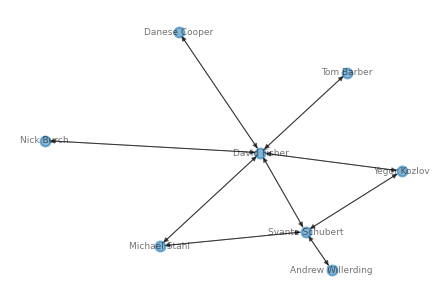

In [40]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)